In [20]:
import os
os.environ['KAGGLE_USERNAME'] = "####" # username from the json file
os.environ['KAGGLE_KEY'] = "###########" # key from the json file
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
# Unzipping the files

import zipfile

with zipfile.ZipFile("/content/flowers-recognition.zip") as z:
    z.extractall(".")

In [22]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dir="/content/flowers"
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.1,#this is the trick
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 shuffle=True)
                                                 
test_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 subset= "validation",
                                                 shuffle=True)


Found 4317 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [43]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [44]:
x = mobile.layers[-6].output
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d_2')>

In [45]:
output = Dense(units=5, activation='softmax')(x)


In [46]:
model = Model(inputs=mobile.input, outputs=output)

In [47]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [48]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [49]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


In [50]:
history = model.fit(x=training_set,
            steps_per_epoch=len(training_set), # there is no batch size here 
            validation_data=test_set,
            validation_steps=len(test_set),
            epochs=30,
            verbose=2,
            callbacks=callbacks)

Epoch 1/30
135/135 - 68s - loss: 0.6090 - accuracy: 0.7707 - val_loss: 0.5348 - val_accuracy: 0.7907
Epoch 2/30
135/135 - 64s - loss: 0.3678 - accuracy: 0.8694 - val_loss: 0.2647 - val_accuracy: 0.9023
Epoch 3/30
135/135 - 64s - loss: 0.2967 - accuracy: 0.8951 - val_loss: 0.2579 - val_accuracy: 0.9140
Epoch 4/30
135/135 - 63s - loss: 0.2651 - accuracy: 0.9083 - val_loss: 0.2039 - val_accuracy: 0.9326
Epoch 5/30
135/135 - 63s - loss: 0.2277 - accuracy: 0.9166 - val_loss: 0.1754 - val_accuracy: 0.9279
Epoch 6/30
135/135 - 67s - loss: 0.1997 - accuracy: 0.9277 - val_loss: 0.1785 - val_accuracy: 0.9395
Epoch 7/30
135/135 - 63s - loss: 0.1905 - accuracy: 0.9344 - val_loss: 0.1636 - val_accuracy: 0.9465
Epoch 8/30
135/135 - 62s - loss: 0.1576 - accuracy: 0.9500 - val_loss: 0.0989 - val_accuracy: 0.9674
Epoch 9/30
135/135 - 63s - loss: 0.1597 - accuracy: 0.9432 - val_loss: 0.1132 - val_accuracy: 0.9674
Epoch 10/30
135/135 - 63s - loss: 0.1316 - accuracy: 0.9553 - val_loss: 0.1089 - val_accura

In [51]:
model.save_weights("Flowers_Classification_Finetuning_MobileNet.h5")

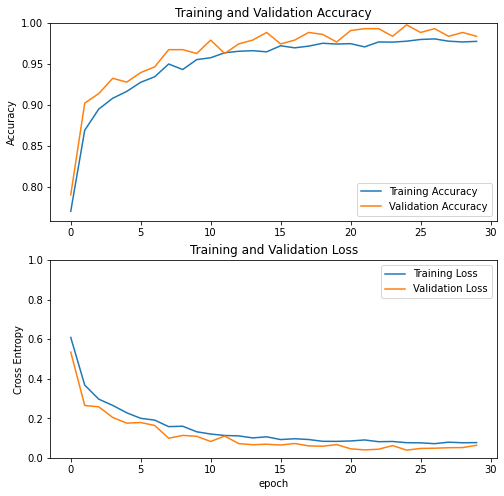

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()